<a href="https://colab.research.google.com/github/krachkofff/ML_2019_november/blob/master/HomeTask_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [32]:
! wget -O dow_jones_index.data https://www.dropbox.com/s/2app6p6qbufrx80/dow_jones_index.data??dl=0

--2020-08-02 20:46:51--  https://www.dropbox.com/s/2app6p6qbufrx80/dow_jones_index.data??dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2app6p6qbufrx80/dow_jones_index.data [following]
--2020-08-02 20:46:51--  https://www.dropbox.com/s/raw/2app6p6qbufrx80/dow_jones_index.data
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfc6e730e3a6c0dc86b65a9608b.dl.dropboxusercontent.com/cd/0/inline/A8t_kOXwyqui4zmfsv8_OnhzFc_xw-6pkDz0B_9g9E0k_4n6_SJkblHvqt555lCgLdZ-ZSYOQ1jD4rYFFCYWvOl-4VoweqMNzIeGKD4ENUwA1ZqC22tP4kiPlEpb7Vw6hs8/file# [following]
--2020-08-02 20:46:51--  https://ucfc6e730e3a6c0dc86b65a9608b.dl.dropboxusercontent.com/cd/0/inline/A8t_kOXwyqui4zmfsv8_OnhzFc_xw-6pkDz0B_9g9E0k_4n6_SJkblHvqt555lCgLdZ-ZSYOQ1jD4rYFFCYW

In [33]:
dataset1 = pd.read_csv('dow_jones_index.data')#Загрузили данные 

In [34]:
dataset1.head()# Посмотрели общую информацию о структуре DF

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [35]:
df = dataset1.drop(['quarter','stock','open','high', 'low', 'close', 'percent_change_price',
              'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
              'next_weeks_open', 'next_weeks_close','percent_change_next_weeks_price',
              'days_to_next_dividend', 'percent_return_next_dividend'], axis = 1)# Удалил лишние столбцы оставил дату и интерсующий меня показатель

In [36]:
df

,date,volume
0,1/7/2011,239655616
1,1/14/2011,242963398
2,1/21/2011,138428495
3,1/28/2011,151379173
4,2/4/2011,154387761
...,...,...
745,5/27/2011,68230855
746,6/3/2011,78616295
747,6/10/2011,92380844
748,6/17/2011,100521400


Производим экспоненциальное сглаживание и визуализируем процесс

In [37]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df.volume, 24)# Значение  n зависит от среднего ее предыдущих значении

69450474.08333333

In [38]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result# Добавляем параметр альфа, определяющий как быстро мы будем забывать предыдущее значение альфа

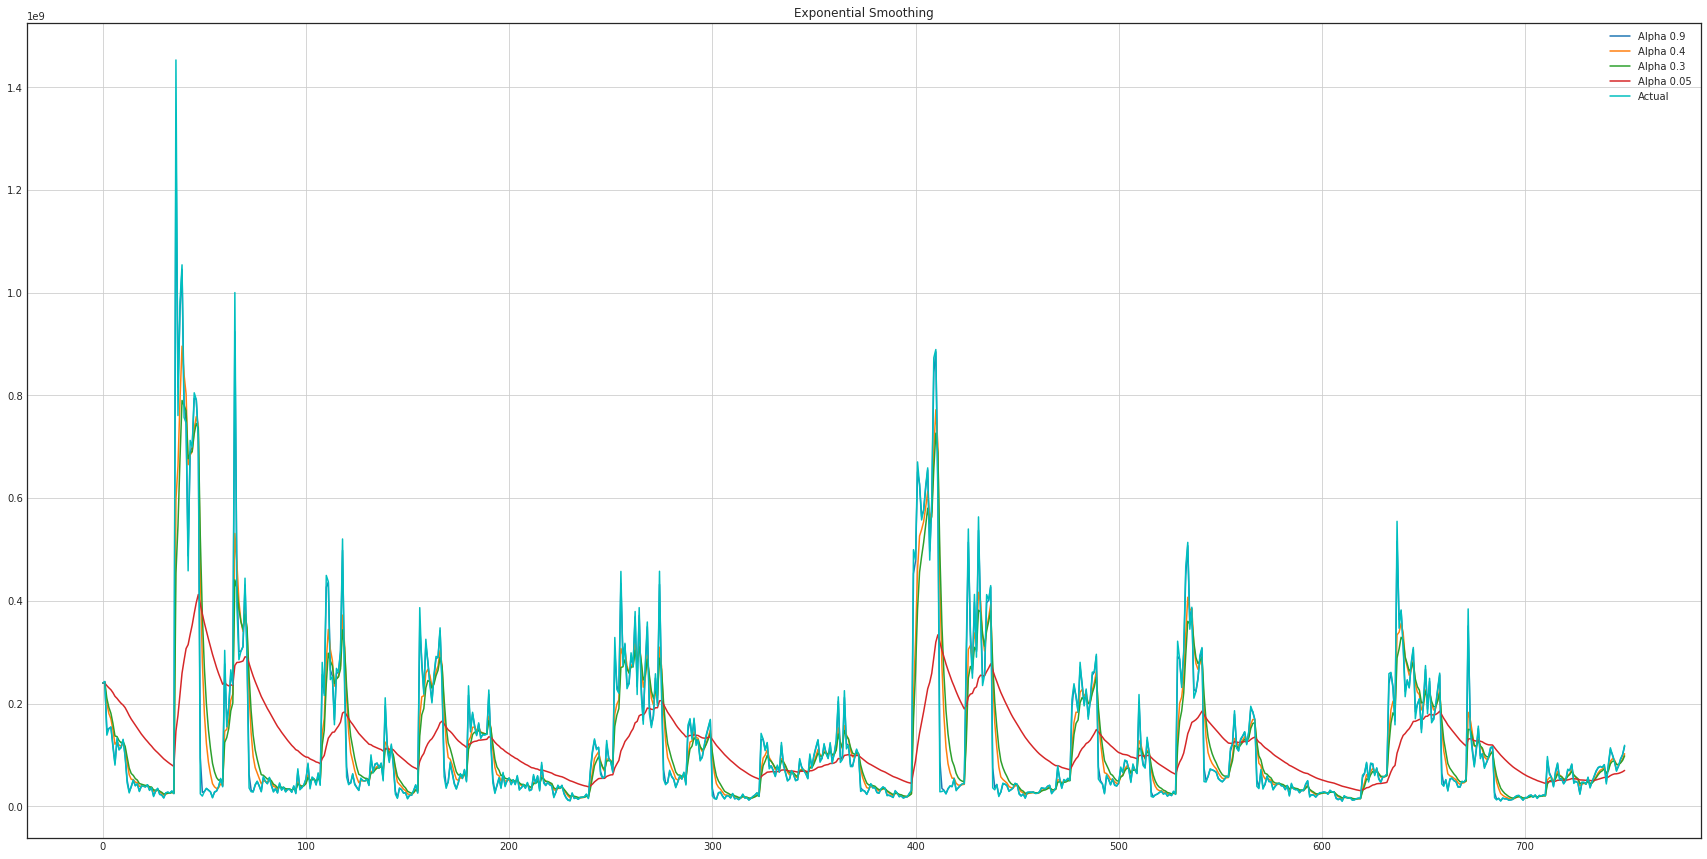

In [9]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(30, 15))
    for alpha in [0.9,0.4,0.3, 0.05]:
        plt.plot(exponential_smoothing(df.volume, alpha), label="Alpha {}".format(alpha))
    plt.plot(df.volume.values, "c", label = "real")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
    

Производим двойное экспоненциальное сглаживание и визуализируем процесс

In [39]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
#        print('level=',level,' trend=',trend)
        
    return result # добавляем параметр бета состоящий из 2-х аргументов (тренд + уровень) уровень это прогнозируемое значение ряда

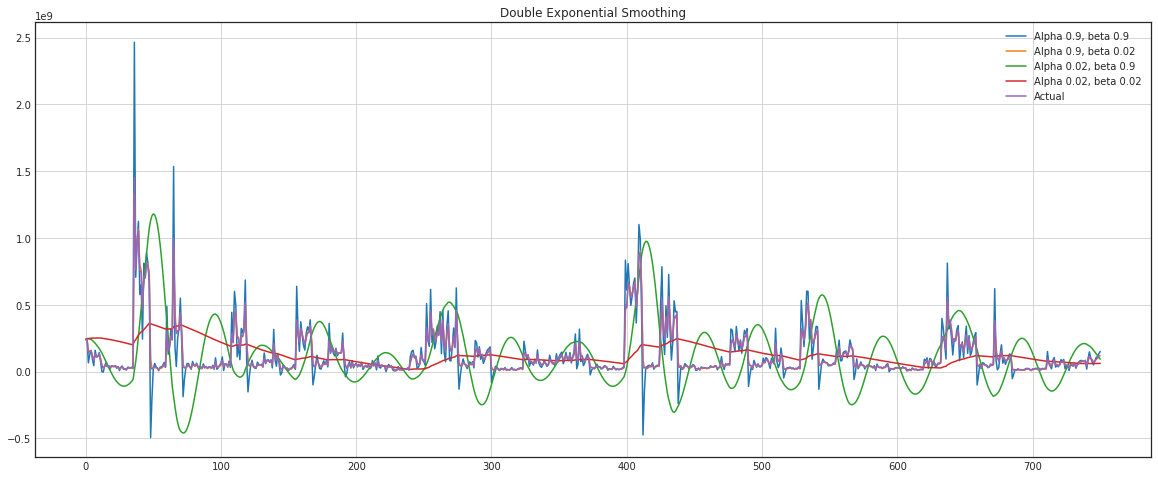

In [40]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(df.volume, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df.volume.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Производим тройное экспоненциальное сглаживание и визуализируем процесс

In [12]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

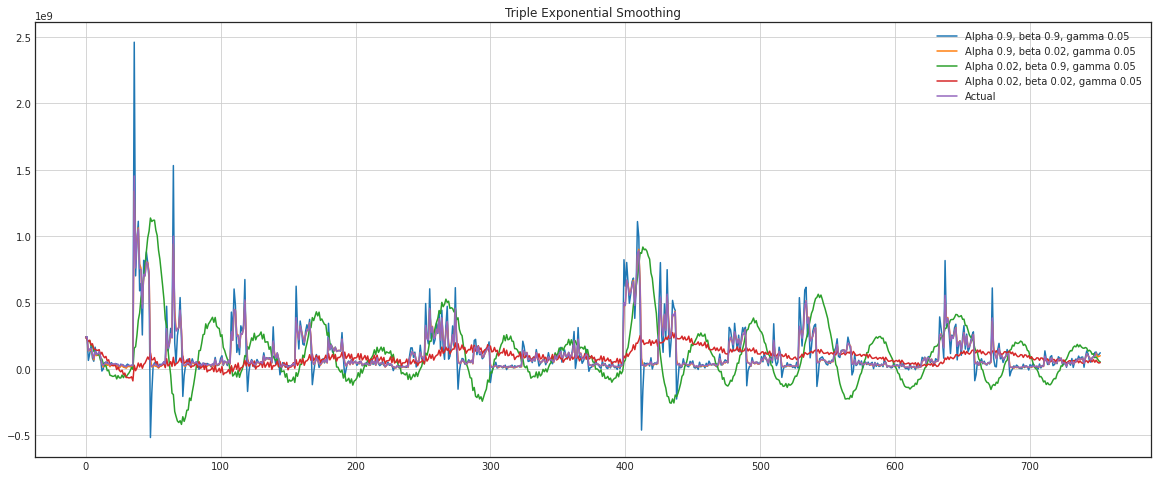

In [41]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
                for gamma in [0.05]:
                    HW = HoltWinters(df.volume, 12, alpha, beta, gamma, 3)
                    HW.triple_exponential_smoothing()
                    plt.plot(HW.result, label="Alpha {}, beta {}, gamma {}".format(alpha, beta, gamma))
    plt.plot(df.volume.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Triple Exponential Smoothing")
    plt.grid(True)# Добавил третий параметр сезонность и наблюдаю как различный набор параметров по разному приближает к актуальным данным

In [42]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [45]:
%%time
data = df.volume[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

ZeroDivisionError: ignored

Критерий Дики-Фуллера: p=0.000101


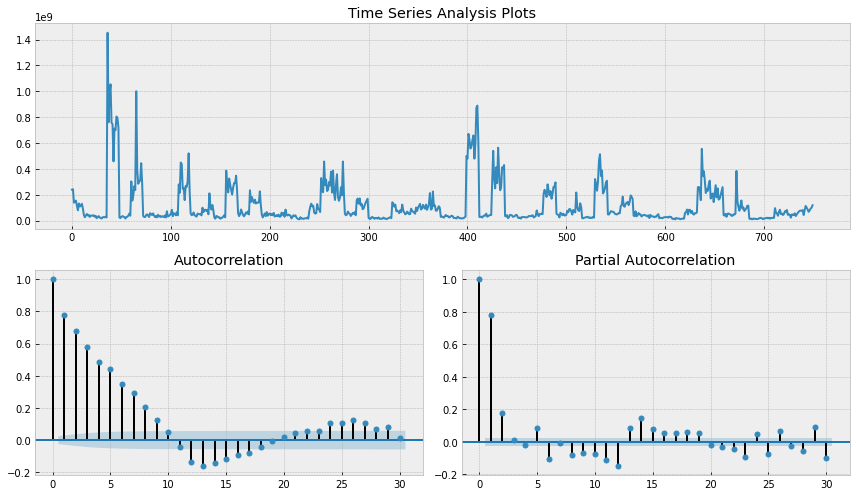

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df.volume, lags=30)

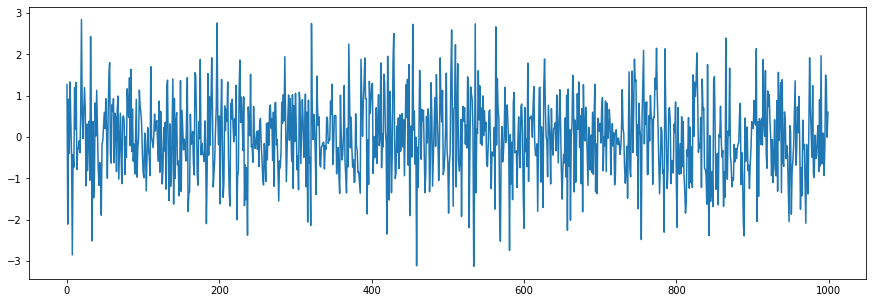

In [16]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'): 
    plt.figure(figsize=(15, 5)) 
plt.plot(white_noise)

Критерий Дики-Фуллера: p=0.000025
Оптимальный параметр преобразования Бокса-Кокса: -0.252767


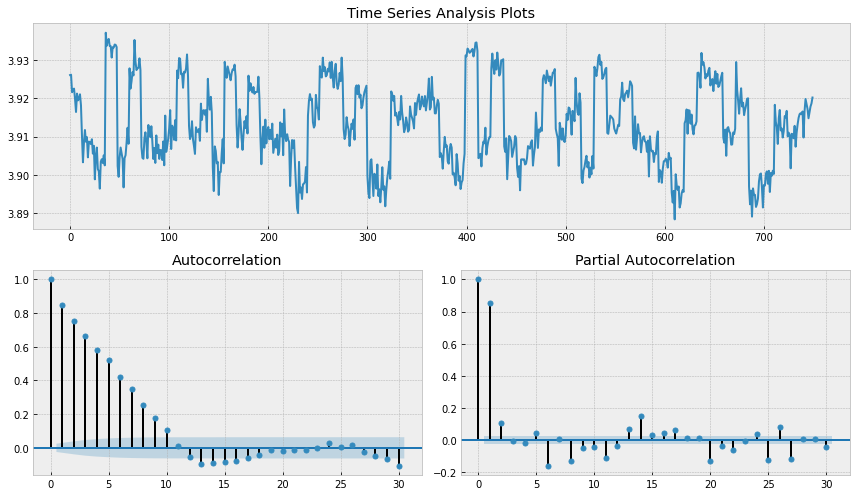

In [17]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = df.copy()
data['volume'], lmbda = scs.boxcox(data.volume+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.volume, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000084


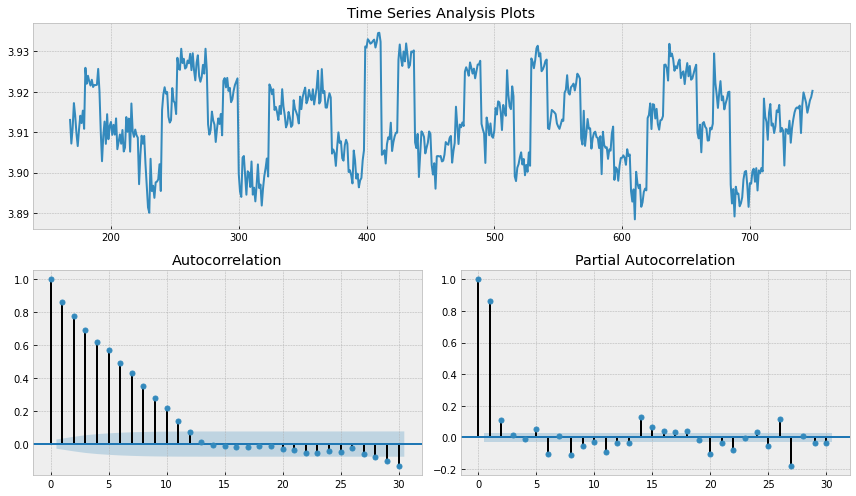

In [18]:
data['volume_seas'] = data.volume - data.volume.shift(24*7)
tsplot(data.volume[24*7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


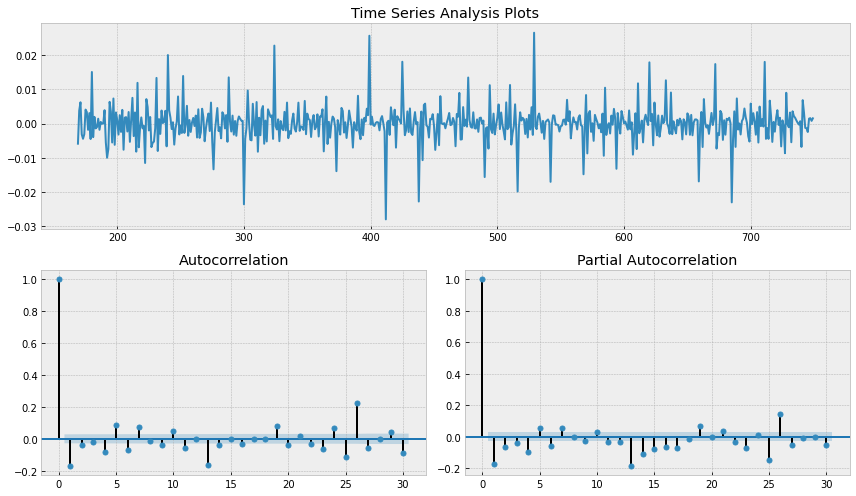

In [19]:
data['volume_diff'] = data.volume - data.volume.shift(1)
tsplot(data.volume_diff[24*7+1:], lags=30)

In [20]:
ps = range(1,3) #range(0, 5)
d=1
qs = range(1,3) #range(0, 4)
Ps = range(1,3) #range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

SARIMA сделана(ниже),  но компьютер зависает при вычислении нижеприведенного кода(оставлял его и на ночь считать, толку нет),
однако более 12% расчета не происходило

%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.volume, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Попробуем fbprophet 

In [21]:
from fbprophet import Prophet

In [22]:
df.rename(columns = {'date':'ds', 'volume':'y'}, inplace = True)
print(df.head())

d_train = df.iloc[:-250]
d_test = df.iloc[-250:]

          ds          y
0   1/7/2011  239655616
1  1/14/2011  242963398
2  1/21/2011  138428495
3  1/28/2011  151379173
4   2/4/2011  154387761


In [23]:
df.head()

,ds,y
0,1/7/2011,239655616
1,1/14/2011,242963398
2,1/21/2011,138428495
3,1/28/2011,151379173
4,2/4/2011,154387761


In [24]:
m = Prophet() #daily_seasonality, weekly_seasonality
m.fit(d_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future = m.make_future_dataframe(freq='H',periods=300) 
future.tail()

,ds
795,2011-07-06 08:00:00
796,2011-07-06 09:00:00
797,2011-07-06 10:00:00
798,2011-07-06 11:00:00
799,2011-07-06 12:00:00


In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
795,2011-07-06 08:00:00,2.145691e+08,-1.699816e+07,4.652002e+08
796,2011-07-06 09:00:00,2.098577e+08,-3.157352e+07,4.140432e+08
797,2011-07-06 10:00:00,2.049714e+08,-7.003413e+05,4.392257e+08
798,2011-07-06 11:00:00,1.999366e+08,-2.999723e+07,4.345399e+08
799,2011-07-06 12:00:00,1.947816e+08,-4.148675e+07,4.240537e+08


In [27]:
prediction = forecast['yhat'][-250:]
actual = d_test['y']
mean_absolute_error(prediction,actual)


149415324.0984899

In [28]:
mean_squared_error(prediction,actual)

2.605923512652935e+16

Вот тут достаточно неожиданно получилась SARIMA

In [29]:
dataset2 = pd.read_csv('dow_jones_index.data')

In [30]:
df2 = dataset1.drop(['quarter','stock','open','high', 'low', 'close', 'percent_change_price',
              'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
              'next_weeks_open', 'next_weeks_close','percent_change_next_weeks_price',
              'days_to_next_dividend', 'percent_return_next_dividend'], axis = 1)

In [31]:
#data.index = data.index.to_datetime()

best_model = sm.tsa.statespace.SARIMAX(df2.volume, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary()) 

KeyboardInterrupt: ignored

In [ ]:
tsplot(best_model.resid[24:], lags=30)

In [ ]:
df2["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = df2.shape[0], end = data.shape[0]+100), lmbda)
forecast = df2.arima_model.append(forecast).values[-150:]
actual = df2.volume.values[-200:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} volume".format(round(mean_absolute_error(df2.dropna().volume, df2.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
df3 = dataset1.drop(['quarter','stock','open','high', 'low', 'close', 'percent_change_price',
              'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
              'next_weeks_open', 'next_weeks_close','percent_change_next_weeks_price',
              'days_to_next_dividend', 'percent_return_next_dividend','volume'], axis = 1)

In [ ]:
df

In [ ]:
data = pd.DataFrame(df)
df.volume = ["y"]

#data.index = data.index.to_datetime()
data["hour"] = data.index
data["weekday"] = data.index
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

In [ ]:
code_mean(df, 'weekday', "y")

In [ ]:

def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    #data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)
    data["hour_average"] = map(code_mean(data[:test_index], 'hour', "y").get, data.hour)

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [ ]:
df4 = dataset1.drop(['quarter','stock','open','high', 'low', 'close', 'percent_change_price',
              'percent_change_volume_over_last_wk', 'previous_weeks_volume', 
              'next_weeks_open', 'next_weeks_close','percent_change_next_weeks_price',
              'days_to_next_dividend', 'percent_return_next_dividend'], axis = 1)

In [ ]:
df4

In [ ]:
Используем линейную регрессию из из пакета статистики SciPy 

In [ ]:
import scipy.stats as sp
y=np.array(df4['volume'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(df4['volume'].dropna()).index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)


P.S Лучший результат показала ЛР